# Differential drive robot (i.e., "segbot") in artificial gravity

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `bumpy` (`True` or `False`) is whether or not the station is "bumpy".

In [113]:
simulator = ae353_segbot.Simulator(
    display=True,
    bumpy=False,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


Create a slider to allow steering the robot.

In [114]:
slider = widgets.FloatSlider(
    value=0.,
    min=-3.,
    max=3.,
    step=0.01,
    description='Centerline:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='75%', border='solid 2px', margin='10px')
)

Choose a camera view from the following options:
* `camera_sideview()`
* `camera_backview()`
* `camera_wideview()`

In [115]:
simulator.camera_backview()

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to both the right and left wheels. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [138]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # FIXME: replace the following lines
        
#         k = np.array([[ -7.07106781, -40.92914195,  -7.07106781, -50.38824045,
#          -62.14467654, -24.10793026],
#         [  7.07106781,  40.92914195,  -7.07106781,  50.38824045,
#          -62.14467654, -24.10793026]])
        k = np.array([[ 4.98992765,  0.5730003 ,  1.04014997,  4.98269867, -2.62435439,
        -4.93434794],
       [ 4.51125227,  0.00852441,  1.23141898,  4.36718085,  4.83248447,
        -1.90489246]])
        x = np.array([[lateral_error], [heading_error], [forward_speed], [turning_rate], [pitch_angle], [pitch_rate]])
        
        u = -k@x
        
        right_wheel_torque = u[0][0]
        left_wheel_torque = u[1][0]
        
        return right_wheel_torque, left_wheel_torque

Create an instance of the controller.

In [139]:
controller = Controller()

Reset the simulator with given initial conditions. You may also change the angular velocity of the station if you like, but - beware! - doing so will change the amount of artificial gravity.

In [140]:
simulator.reset(
    initial_speed=1.,
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity=-0.5,
)

Reset the controller.

In [141]:
controller.reset()

Reset the slider.

In [142]:
slider.value = 0.

Run the simulator with steering. Note that this function runs **asynchronously** to allow user input. You **must** wait until the simulator finishes running before doing anything else in the notebook.

In [143]:
# Show the slider, to allow steering the robot
display(slider)

# Run the simulation asynchronously, to allow using the slider
obj = asyncio.ensure_future(
    simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
        slider=slider,        # <-- optional (allow steering)
        print_debug=True,     # <-- optional (say when the simulator has finished running)
    )
)

FloatSlider(value=0.0, description='Centerline:', layout=Layout(border_bottom='solid 2px', border_left='solid …

Simulated 501 time steps in 5.0228 seconds (99.7444 time steps per second)


Get results of running the simulator with steering.

In [122]:
if obj.done():
    data = obj.result()
else:
    print('You cannot get results until after the simulator is done running.')

Run the simulator with no steering.

In [123]:
data = await simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
    slider=None,          # <-- optional (allow no steering)
)

Get, show, and save a snapshot of the simulation after the last time step.

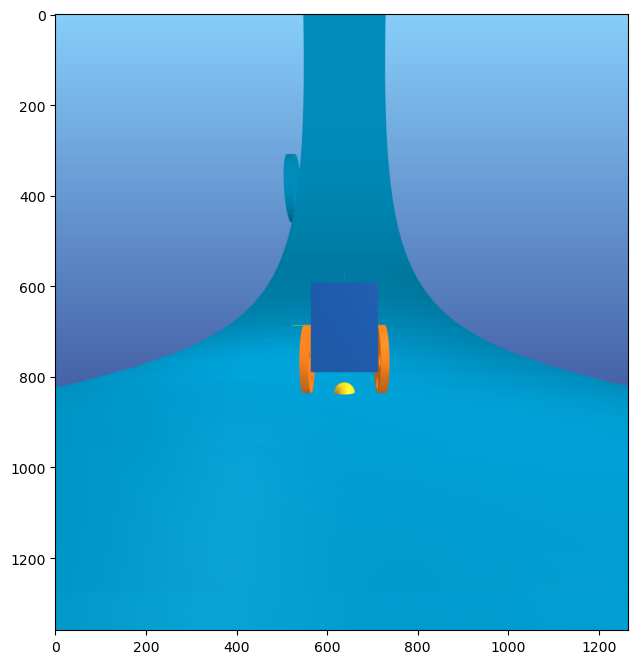

In [124]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

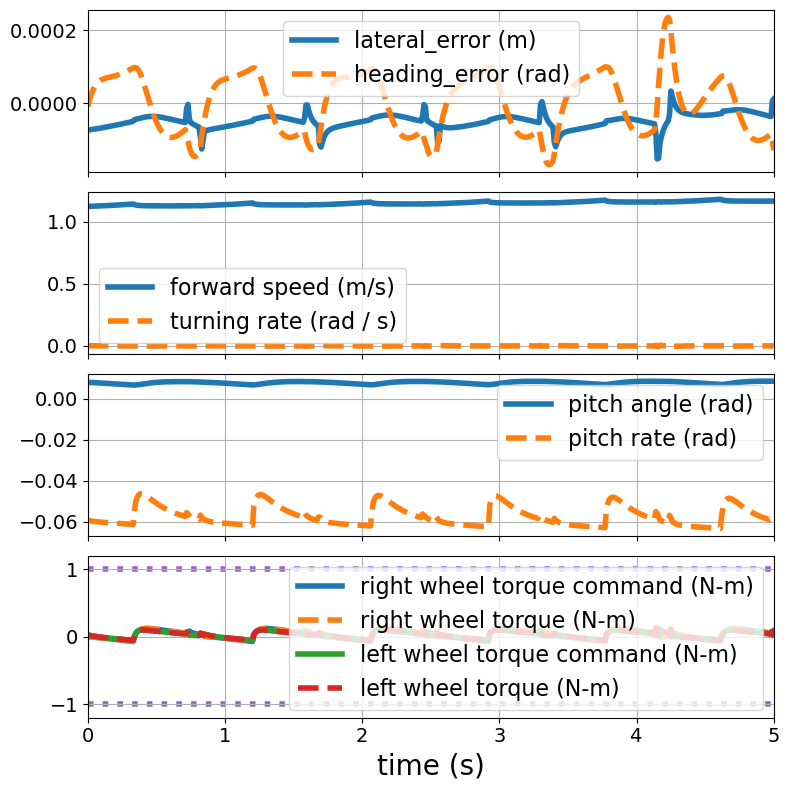

In [125]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [ ]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)